### Import Packages

In [1]:
import os, sys
import numpy as np
import pandas
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from cv_bridge import CvBridge

import rosbag
from utils import rosbag_utils
from utils.navigation_utils import *


### Load Data

In [2]:
bag_file = "/media/peng/Samsung/2022-10-14/camera_gps_2022-10-14-09-53-49.bag"
# bag_file = "/media/peng/Samsung/2022-10-14/camera_gps_2022-10-14-09-57-49.bag"
# bag_file = "/media/peng/Samsung/2022-10-14/camera_gps_2022-10-14-10-01-08.bag"

# bag_file = "/media/peng/Samsung/2022-10-17/camera_gps_2022-10-17-13-03-08.bag"

bag = rosbag.Bag(bag_file, "r")

rosbag_utils.print_bag_topics(bag)

Available topics: 
------------------------------
'/d435i/aligned_depth_to_color/camera_info'   (msg_type=sensor_msgs/CameraInfo, frequency=5.99Hz)
'/d435i/aligned_depth_to_color/image_raw/compressed'   (msg_type=sensor_msgs/CompressedImage, frequency=5.99Hz)
'/d435i/color/camera_info'   (msg_type=sensor_msgs/CameraInfo, frequency=5.99Hz)
'/d435i/color/image_raw/compressed'   (msg_type=sensor_msgs/CompressedImage, frequency=5.99Hz)
'/mavros/altitude'   (msg_type=mavros_msgs/Altitude, frequency=10.07Hz)
'/mavros/global_position/compass_hdg'   (msg_type=std_msgs/Float64, frequency=10.09Hz)
'/mavros/global_position/global'   (msg_type=sensor_msgs/NavSatFix, frequency=10.09Hz)
'/mavros/global_position/local'   (msg_type=nav_msgs/Odometry, frequency=10.09Hz)
'/mavros/global_position/raw/fix'   (msg_type=sensor_msgs/NavSatFix, frequency=7.95Hz)
'/mavros/global_position/raw/gps_vel'   (msg_type=geometry_msgs/TwistStamped, frequency=7.95Hz)
'/mavros/global_position/raw/satellites'   (msg_type=

### Read ros topics

In [3]:
# read topics
global_position = rosbag_utils.get_topic_from_bag(bag, "/mavros/global_position/global")
compass_hdg = rosbag_utils.get_topic_from_bag(bag, "/mavros/global_position/compass_hdg")
gps_status = rosbag_utils.get_topic_from_bag(bag, "/mavros/gpsstatus/gps1/raw")

piksi_global_position = rosbag_utils.get_topic_from_bag(bag, "/piksi/navsatfix_best_fix")
piksi_receiver_state = rosbag_utils.get_topic_from_bag(bag, "/piksi/debug/receiver_state")


topic: /mavros/global_position/global
fields: ['altitude', 'header', 'latitude', 'longitude', 'position_covariance', 'position_covariance_type', 'status']
messages: 1299
frequency: 10.0Hz
------------------------------
topic: /mavros/global_position/compass_hdg
fields: ['data']
messages: 1299
frequency: 10.0Hz
------------------------------
topic: /mavros/gpsstatus/gps1/raw
fields: ['alt', 'alt_ellipsoid', 'cog', 'dgps_age', 'dgps_numch', 'eph', 'epv', 'fix_type', 'h_acc', 'hdg_acc', 'header', 'lat', 'lon', 'satellites_visible', 'v_acc', 'vel', 'vel_acc', 'yaw']
messages: 1039
frequency: 8.0Hz
------------------------------
topic: /piksi/navsatfix_best_fix
fields: ['altitude', 'header', 'latitude', 'longitude', 'position_covariance', 'position_covariance_type', 'status']
messages: 1299
frequency: 10.0Hz
------------------------------
topic: /piksi/debug/receiver_state
fields: ['cn0', 'cn0_bds', 'cn0_gal', 'cn0_glonass', 'cn0_gps', 'cn0_sbas', 'external_antenna_present', 'fix_mode', 'he

### Load Map

In [4]:
def configure_map_plot(axis, field_bound):
    axis.set_xlabel('x [m]')
    axis.set_ylabel('y [m]')
    axis.set_aspect(1)
    axis.set_xlim(field_bound['local'][0])
    axis.set_ylim(field_bound['local'][1])
    axis.ticklabel_format(useOffset=False)

def draw_vertice(axis, vertice, s=10, color='b'):
    axis.scatter(vertice[:,0], vertice[:,1], s=s, color=color)

def draw_line(axis, line, color='k', linestyle='-', linewidth=1.0):
    axis.plot(line[:,0], line[:,1], color=color, linestyle=linestyle, linewidth=linewidth)

def draw_polygon(axis, vertice, color='b', linestyle='-', linewidth=3.0, alpha=0.1):
    axis.add_patch(patches.Polygon(vertice, color=color, linestyle=linestyle, linewidth=linewidth, alpha=alpha))

def draw_single_data(axis, data, vertice=True, treelines=True, centerline=True, polygon=False):
    # vertice
    if vertice:
        draw_vertice(axis, data['vertice'])
    # treeline
    if treelines:
        draw_line(axis, data['treelines_actual'][0], color='g')
        draw_line(axis, data['treelines_actual'][1], color='g')
    # centerline
    if centerline:
        draw_line(axis, data['centerline'], color='k', linestyle='--')
    # polygon
    if polygon:
        draw_polygon(axis, data['vertice_actual'])

#### 
data_path = "./ground_truth/plant_field.pkl"

# Configure map
with open(data_path, 'rb') as file:
    data = pickle.load(file)

field_bound = {
    'latlon': data['field_bound_latlon'],
    'local': data['field_bound_local'],
}

utm_T_local = data['utm_T_local']

# # plot
# fig, axes = plt.subplots(1,1,figsize=(10, 8))
# configure_map_plot(axes, field_bound)

# for i in range(24):
#     draw_single_data(axes, data['row_data'][i])

# fig.tight_layout()

### Plot drone pose on map

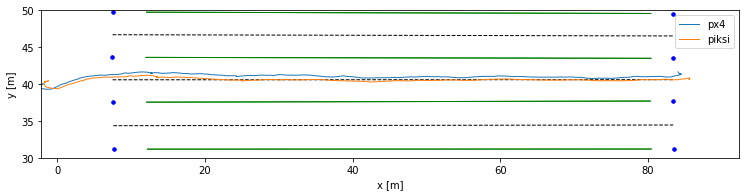

In [5]:
# plot
fig, axes = plt.subplots(1,1,figsize=(10, 8))
configure_map_plot(axes, field_bound)

for i in range(24):
    draw_single_data(axes, data['row_data'][i])

fig.tight_layout()

# local position
local_pos_px4 = []
for i in range(len(global_position)):
    pos_xy = get_local_xy_from_latlon(
        global_position['latitude'].iloc[i],
        global_position['longitude'].iloc[i],
        utm_T_local,
    )
    local_pos_px4.append(pos_xy[:2])
local_pos_px4 = np.array(local_pos_px4)

local_pos_piksi = []
for i in range(len(piksi_global_position)):
    pos_xy = get_local_xy_from_latlon(
        piksi_global_position['latitude'].iloc[i],
        piksi_global_position['longitude'].iloc[i],
        utm_T_local,
    )
    local_pos_piksi.append(pos_xy[:2])
local_pos_piksi = np.array(local_pos_piksi)

axes.plot(local_pos_px4[:,0], local_pos_px4[:,1], color='C0', linewidth=1.0, label='px4')
axes.plot(local_pos_piksi[:,0], local_pos_piksi[:,1], color='C1', linewidth=1.0, label='piksi')
axes.set_ylim([30, 50])
# axes.set_ylim([60, 80])
axes.legend()


### Process Data

In [6]:
# read topics
color_image = rosbag_utils.get_topic_from_bag(bag, "/d435i/color/image_raw/compressed")
depth_image = rosbag_utils.get_topic_from_bag(bag, "/d435i/aligned_depth_to_color/image_raw/compressed")

global_position = rosbag_utils.get_topic_from_bag(bag, "/mavros/global_position/global")
compass_hdg = rosbag_utils.get_topic_from_bag(bag, "/mavros/global_position/compass_hdg")
gps_status = rosbag_utils.get_topic_from_bag(bag, "/mavros/gpsstatus/gps1/raw")

piksi_global_position = rosbag_utils.get_topic_from_bag(bag, "/piksi/navsatfix_best_fix")
piksi_receiver_state = rosbag_utils.get_topic_from_bag(bag, "/piksi/debug/receiver_state")

ros_time, sync_topics = rosbag_utils.timesync_topics([
    color_image,
    depth_image,
    piksi_global_position,
    compass_hdg
])
    
color_image_sync = sync_topics[0]
depth_image_sync = sync_topics[1]
piksi_global_position_sync = sync_topics[2]
compass_hdg_sync = sync_topics[3]

topic: /d435i/color/image_raw/compressed
fields: ['data', 'format', 'header']
messages: 778
frequency: 5.99Hz
------------------------------
topic: /d435i/aligned_depth_to_color/image_raw/compressed
fields: ['data', 'format', 'header']
messages: 778
frequency: 5.99Hz
------------------------------
topic: /mavros/global_position/global
fields: ['altitude', 'header', 'latitude', 'longitude', 'position_covariance', 'position_covariance_type', 'status']
messages: 1299
frequency: 10.0Hz
------------------------------
topic: /mavros/global_position/compass_hdg
fields: ['data']
messages: 1299
frequency: 10.0Hz
------------------------------
topic: /mavros/gpsstatus/gps1/raw
fields: ['alt', 'alt_ellipsoid', 'cog', 'dgps_age', 'dgps_numch', 'eph', 'epv', 'fix_type', 'h_acc', 'hdg_acc', 'header', 'lat', 'lon', 'satellites_visible', 'v_acc', 'vel', 'vel_acc', 'yaw']
messages: 1039
frequency: 8.0Hz
------------------------------
topic: /piksi/navsatfix_best_fix
fields: ['altitude', 'header', 'lati

Flying in row 4
Flying direction: 1


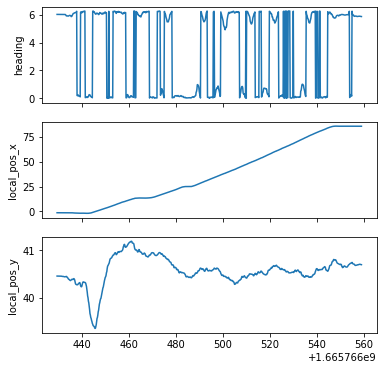

In [8]:
# heading
heading = np.radians(compass_hdg_sync['data'])
for i in range(len(heading)):
    heading.iloc[i] = wrap_2pi(heading.iloc[i] - np.pi/2)


# local pos
local_pos_x = []
local_pos_y = []
for i in range(len(piksi_global_position_sync)):
    pos_xy = get_local_xy_from_latlon(
        piksi_global_position_sync['latitude'].iloc[i],
        piksi_global_position_sync['longitude'].iloc[i],
        utm_T_local,
    )
    local_pos_x.append(pos_xy[0])
    local_pos_y.append(pos_xy[1])

local_pos_x = np.array(local_pos_x)
local_pos_y = np.array(local_pos_y)

results = {
    'time': piksi_global_position_sync['ros_time'],
    'heading': heading,
    'local_pos_x': local_pos_x,
    'local_pos_y': local_pos_y,
}
results = pandas.DataFrame(results)

fig, axes = plt.subplots(3,1,sharex=True,figsize=(6,6))
axes[0].plot(ros_time, heading)
axes[0].set_ylabel('heading')
axes[1].plot(ros_time, local_pos_x)
axes[1].set_ylabel('local_pos_x')
axes[2].plot(ros_time, local_pos_y)
axes[2].set_ylabel('local_pos_y')

## bitmask1: check whether in polygon
# find which row
all_index = []
for x, y in zip(local_pos_x, local_pos_y):
    current_pose = [x, y]

    index = find_area_index(current_pose, data['row_data'])
    if index is not None:
        all_index.append(index)

    if len(all_index) > 10:
        break

row_index = int(np.array(all_index).mean())
print("Flying in row %d" % row_index)

current_polygon = Polygon([vertex for vertex in data['row_data'][row_index]['vertice_actual']])
bitmask1 = []
for x, y in zip(local_pos_x, local_pos_y):
    current_pose = [x, y]
    bitmask1.append(whether_in_polygon(current_pose, current_polygon))

## bitmask2: check heading
if local_pos_x[0] > data['row_data'][row_index]['treelines'][0][1][0]:
    direction = -1
    heading_range = [-3*np.pi/2, -np.pi/2]
else:
    direction = 1
    heading_range = [-np.pi/2, np.pi/2]
print("Flying direction: %d" % direction)

bitmask2 = []
for i in range(len(heading)):
    res = (heading_range[0] <= heading.iloc[i] <= heading_range[1])
    bitmask2.append(res)


In [ ]:
# Images
bridge = CvBridge()

# RGB
color_image_list = []
for i in range(len(color_image_sync)):
    np_arr = np.frombuffer(color_image_sync['data'].iloc[i], np.uint8)
    image_np = cv2.imdecode(np_arr, cv2.IMREAD_COLOR) # RGB
    # image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    color_image_list.append(image_np)

plt.imshow(image_np)
print("%d color images in total" % len(color_image_list))

# # Depth
# depth_image_list = []
# for i in range(len(depth_image_sync)):
#     np_arr = np.frombuffer(depth_image_sync['data'].iloc[i], np.uint8)
#     image_np = cv2.imdecode(np_arr, cv2.IMREAD_COLOR) # RGB
#     print(image_np.shape)
#     depth_image_list.append(image_np)

# plt.imshow(depth_image_list[100])
# print("%d depth images" % len(color_image_list))

In [ ]:
## Apply bitmasks
filtered_results = pandas.DataFrame()
for i in range(len(results)):
    if bitmask1[i] and bitmask2[i]:
        res = {}
        res['time'] = results['time'].iloc[i]
        res['heading'] = results['heading'].iloc[i]
        res['local_pos_x'] = results['local_pos_x'].iloc[i]
        res['local_pos_y'] = results['local_pos_y'].iloc[i]
        res['index'] = i
        filtered_results = filtered_results.append(res, ignore_index=True)

# print(filtered_results)
print("{:.2%} of raw data is valid.".format(len(filtered_results) / len(results)))